In [7]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from src import detection
import noisereduce as nr
from src.utils import data
from engine_configs import CONFIGS


class EngineDataset(Dataset):
    def __init__(self, dataset_paths, config, batch_size, reduce_noise=True,
                  cut_freq_Hz=200, train=None, test_fraction=0.5, 
                 hanning_size=None, window_size_seconds=2):
        super().__init__()
        self.batch_size = batch_size
        self.config = config
        self.dataset_paths = dataset_paths
        self.reduce_noise = reduce_noise
        self.cut_freq_Hz = cut_freq_Hz
        self.hanning_size = hanning_size
        self.window_size_seconds = window_size_seconds
        
        self.anomaly_names = ['no anomalies']
        self.anomaly_freqs = []
        for anomaly_idx, anomaly_name in enumerate(sorted(detection.ANOMALIES_FREQS.keys())):
            self.anomaly_names.append(anomaly_name)
            anomaly_freqs = [f for f in detection.ANOMALIES_FREQS[anomaly_name](config) if 0<f<self.cut_freq_Hz]
            embeddings = np.zeros(cut_freq_Hz*window_size_seconds)
            freqs = np.linspace(0, cut_freq_Hz, cut_freq_Hz*window_size_seconds)
            for f in anomaly_freqs:
                embeddings[min(np.arange(freqs.shape[0]), key=lambda i:abs(f-freqs[i]))] = 1
            self.anomaly_freqs.append(embeddings)
        self.anomaly_freqs = np.array(self.anomaly_freqs)
        self.datasets = {}
        for anomaly_type, datasets in dataset_paths.items():
            dfs = []
            for dataset_path in datasets:
                try:
                    df = data.read(dataset_path)
                except:
                    continue
                if train==True:
                    to = int((1-test_fraction)*df.shape[0])
                    df = df.iloc[:to].reset_index(drop=True)
                    df.time -= df.time.min()
                elif train==False:
                    to = int((1-test_fraction)*df.shape[0])
                    df = df.iloc[to:].reset_index(drop=True)
                    df.time -= df.time.min()
                dfs.append(df)
            self.datasets[anomaly_type] = dfs
    
    def __len__(self):
        return self.batch_size
    
    def __getitem__(self, idx):
        label = np.random.choice(list(self.datasets.keys()))
        label_index = self.anomaly_names.index(label)
        df = self.datasets[label][np.random.choice(np.arange(len(self.datasets[label])))]
        if self.window_size_seconds:
            df = data.get_random_window(df, self.window_size_seconds)
        if self.hanning_size:
            df.value = np.convolve(df.value, np.hanning(self.hanning_size))[:df.shape[0]]
        if self.reduce_noise:
            df.value = nr.reduce_noise(df.value, int(self.config['f_sampling']),
                                       freq_mask_smooth_hz=self.cut_freq_Hz)
        yf, freqs = data.time_to_freq_transform(df, self.config)
        mask = freqs < self.cut_freq_Hz
        freqs, yf = [x[mask] for x in [freqs, yf]]
        yf = (yf - 40)/80
        return np.concatenate((np.expand_dims(yf, 0), self.anomaly_freqs), 0), label_index, label
        

In [8]:
train_files = {
    'no anomalies': ['data/0702 без перекосов фаза A.txt', 'data/ВКЛ-ВЫКЛ нагрузка 100% 11 01.txt',
                     'data/холостой ход 11 01.txt', 'data/нагрузка 100% 11 01.txt'],
    'inter-cell shortages': ['data/0702  межвитковые фазы A ток фазы А.txt'],
    'unknown mechanical defect': ['data/20_01_1460_об_мин_с_дисбалансом_ротора.txt'],
}

test_files = train_files

# from glob import glob
# from collections import defaultdict
# train_files = defaultdict(list)
# for filename in glob('data/*.txt'):
#     if filename in [x for y in test_files.values() for x in y]: continue
#     if not filename.split('/')[1].startswith('21'): continue
#     if "дисбаланс" in filename:
#         train_files['unknown mechanical defect'].append(filename)
#     else:
#         train_files['no anomalies'].append(filename)
# train_files

In [9]:
batch_size = 32
train_dataset = EngineDataset(train_files, CONFIGS['Liman'], batch_size, train=True)
test_dataset = EngineDataset(test_files, CONFIGS['Liman'], batch_size, train=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [10]:
batch = next(iter(train_loader))[0]

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 400

In [ ]:
batch = next(iter(test_loader))[0]

In [6]:
from torch import nn
import torch

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

model = nn.Sequential(
    nn.Conv1d(8, 16, 5),
    nn.Softplus(),
    nn.BatchNorm1d(16),
    
    nn.Conv1d(16, 32, 5),
    nn.Softplus(),
    nn.BatchNorm1d(32),
    
    nn.Conv1d(32, 64, 5),
    nn.Softplus(),
    nn.BatchNorm1d(64),
    
    nn.Conv1d(64, 64, 3),
    nn.Softplus(),
    nn.AdaptiveAvgPool1d(1),
    Reshape(-1, 64),
    
    nn.Linear(64, 8)
)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv1d(8, 16, kernel_size=(5,), stride=(1,))
  (1): Softplus(beta=1, threshold=20)
  (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
  (4): Softplus(beta=1, threshold=20)
  (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv1d(32, 64, kernel_size=(5,), stride=(1,))
  (7): Softplus(beta=1, threshold=20)
  (8): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (10): Softplus(beta=1, threshold=20)
  (11): AdaptiveAvgPool1d(output_size=1)
  (12): Reshape()
  (13): Linear(in_features=64, out_features=8, bias=True)
)

# Train

In [7]:
from torch.optim import RAdam
from tqdm.auto import tqdm
from torch.nn import functional as F

model.train()
opt = RAdam(model.parameters(), lr=1e-3)
n_epoches = 10000
test_freq = 500
best_acc = 0
tbar = tqdm(range(n_epoches), total=n_epoches, desc='?')
for epoch in tbar:
    batch_X, y_true, _ = next(iter(train_loader))
    batch_X, y_true = [x.float().to(device) for x in [batch_X, y_true]]
    y_pred = model(batch_X)
    loss = F.cross_entropy(y_pred, y_true.long())
    loss.backward()
    opt.step()
    opt.zero_grad()
    if epoch % test_freq == 0:
        model.eval()

        y_true = []
        y_pred = []
        n_evaluation_stages = 100
        for epoch in range(n_evaluation_stages):
            batch_X, y_true_, _ = next(iter(test_loader))
            batch_X, y_true_ = [x.float().to(device) for x in [batch_X, y_true_]]
            with torch.no_grad():
                y_pred_ = model(batch_X)
            y_true.append(y_true_.detach().cpu().numpy())
            y_pred.append(y_pred_.detach().cpu().numpy())
        y_true = np.array(y_true).astype(int).reshape(-1)
        y_pred = np.array(y_pred).argmax(-1).reshape(-1)
        
        test_acc = (y_true == y_pred).mean()
        if test_acc > best_acc:
            best_acc = test_acc
            y_true_best = y_true
            y_pred_best = y_pred
        model.train()
    tbar.set_description(f'Loss: {loss.item(): .3f}\t Test acc: {test_acc: .3f}\t Best acc: {best_acc: .3f}')
    tbar.update()
    

Loss:  0.018	 Test acc:  0.836	 Best acc:  0.958:  45%|▍| 4531/10000 [2:04:15<2:


KeyboardInterrupt: 

# Evaluation

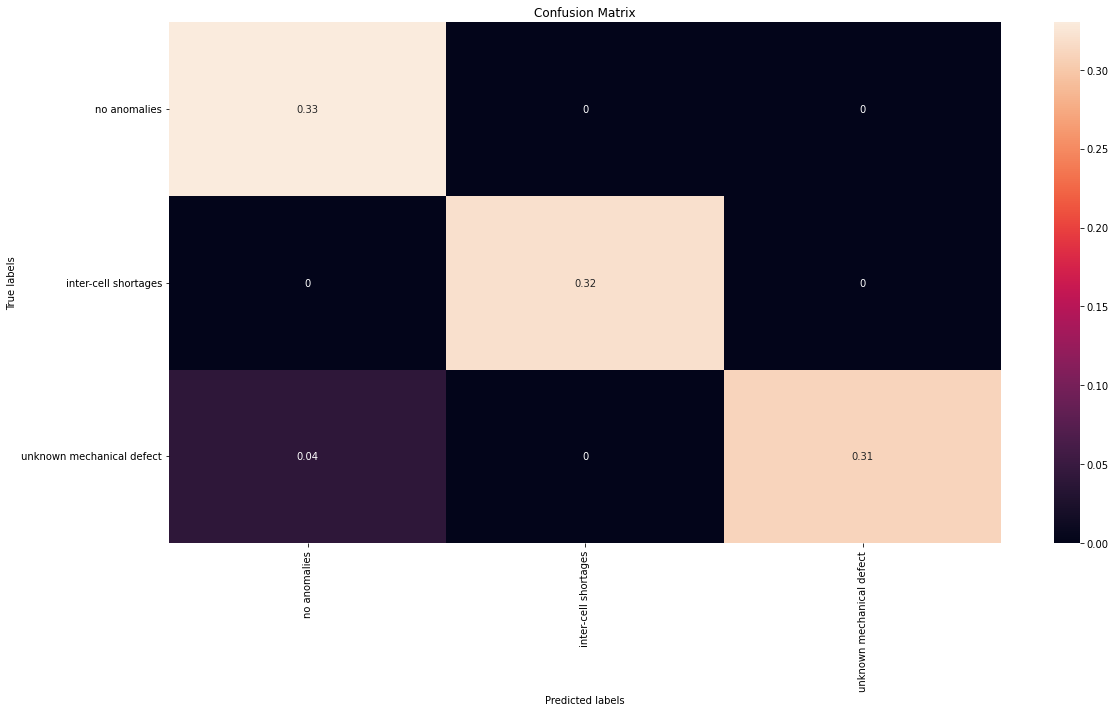

In [11]:
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt

plt.figure(figsize=(17,10))
labels = [name for i, name in enumerate(test_dataset.anomaly_names) if i in y_true]
conf_matrix = confusion_matrix(y_true=y_true_best, y_pred=y_pred_best, normalize='all').round(2)

ax= plt.subplot()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels, rotation=90); ax.yaxis.set_ticklabels(labels, rotation=0);
plt.tight_layout()

In [12]:
(y_true_best==y_pred_best).mean()

0.9584375

In [35]:
from torchsummary import summary
summary(model, (8,400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 396]             656
          Softplus-2              [-1, 16, 396]               0
       BatchNorm1d-3              [-1, 16, 396]              32
            Conv1d-4              [-1, 32, 392]           2,592
          Softplus-5              [-1, 32, 392]               0
       BatchNorm1d-6              [-1, 32, 392]              64
            Conv1d-7              [-1, 64, 388]          10,304
          Softplus-8              [-1, 64, 388]               0
       BatchNorm1d-9              [-1, 64, 388]             128
           Conv1d-10              [-1, 64, 386]          12,352
         Softplus-11              [-1, 64, 386]               0
AdaptiveAvgPool1d-12                [-1, 64, 1]               0
          Reshape-13                   [-1, 64]               0
           Linear-14                   